# Addition Interpretability Analysis

This CoLab underpins the [Addition Interpretability](https://www.overleaf.com/project/64c75f5e7211fe5cb86623d2) paper. It builds on Neel Nanda's work on the 5 Digit Addition (e.g. 12345+44444=056789) 1 layer Transformer model. It helped elucidate the model's internal algorithm.


This workbook includes content from:

* [A Mechanistic Interpretability Analysis of Grokking (Stable)](https://colab.research.google.com/drive/1F6_1_cWXE5M7WocUcpQWp3v8z4b1jL20#scrollTo=XdjjunLxwi_b)

* [Non_Modular_Addition_Grokking_Tasks.ipynb](https://github.com/mechanistic-interpretability-grokking/progress-measures-paper/blob/main/Non_Modular_Addition_Grokking_Tasks%20(1).ipynb)

* [Grokking_Demo.ipynb](https://github.com/neelnanda-io/TransformerLens/blob/main/demos/Grokking_Demo.ipynb)

I'm very grateful to the people who created those resources.



## Setup
Don't bother reading this section


In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEVELOPMENT_MODE = True
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install kaleido
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git@new-demo
    %pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
    #%pip install circuitsvis
    %pip install jaxtyping

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.9 MB/s eta 0:00:00
  Cloning https://github.com/neelnanda-io/TransformerLens.git (to revision new-demo) to /tmp/pip-req-build-bd09isoq
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-bd09isoq
  Running command git checkout -b new-demo --track origin/new-demo
  Switched to a new branch 'new-demo'
  Branch 'new-demo' set up to track remote branch 'new-demo' from 'origin'.
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 25879ea6d969e8e9c962957bc945be42de522b4a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5

In [2]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import kaleido
import plotly.io as pio

if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

import plotly.express as px
import plotly.graph_objects as go

Using renderer: colab


In [3]:
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

In [4]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from torchtyping import TensorType as TT
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
from IPython.display import display

import circuitsvis as cv


In [5]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [6]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

## Addition Interpretability - Configuration

* This model can be successfully trained to do 2, 5, 10, 15 etc digit integer addition. The default is n_digits = 5.
* The model can be successfully trained with 2, 3 or 4 attention heads. The  default is n_heads = 3.


In [7]:
#@markdown Model
n_layers = 1
d_vocab = 12
n_heads = 3 #@param
d_model = ( 512 // n_heads ) * n_heads    # About 512, and divisible by n_heads
d_head = d_model // n_heads
d_mlp = 4 * d_model
seed = 129000 #@param

#@markdown Data
n_digits = 5 #@param
n_ctx = 3 * n_digits + 3
act_fn = 'relu'
batch_size = 64 #@param

#@markdown Optimizer
lr = 0.00008 #@param
weight_decay = 0.1 #@param
n_epochs = 5000      # 3000 + (n_digits//5) * 1000

# Special tokens
PLUS_INDEX = 10
EQUALS_INDEX = 11

In [8]:
# Train or load model? Training saves the model weights in a temporary CoLab file
train_model = True #@param
# The name of the temporary CoLab file
PthLocation = "model.pth"

# Optional. Show title in graphs
show_graph_titles = True
# Optional. Save graphs to PDF
save_graph_pdf = False
# Optional. Performs data-generator sanity checks on 1% of training data
unit_tests = False

In [9]:
# Embedding / Unembedding

def tokens_to_string(tokens):
    tokens = utils.to_numpy(tokens)
    x = "".join([str(i) for i in tokens[:n_digits]])
    y = "".join([str(i) for i in tokens[n_digits+1:n_digits*2+1]])
    z = "".join([str(i) for i in tokens[n_digits*2+2:]])
    return f"{x}+{y}={z}"

def string_to_tokens(string, batch=False):
    lookup = {str(i):i for i in range(10)}
    lookup['+']=PLUS_INDEX
    lookup['=']=EQUALS_INDEX
    tokens = [lookup[i] for i in string if i not in '\n ']
    if batch:
        return torch.tensor(tokens)[None, :]
    else:
        return torch.tensor(tokens)

In [10]:
# Transformer creation

# Structure is documented at https://neelnanda-io.github.io/TransformerLens/transformer_lens.html#transformer_lens.HookedTransformerConfig.HookedTransformerConfig
cfg = HookedTransformerConfig(
    n_layers = n_layers,
    n_heads = n_heads,
    d_model = d_model,
    d_head = d_head,
    d_mlp = d_mlp,
    act_fn = act_fn,
    normalization_type = 'LN',
    d_vocab=d_vocab,
    d_vocab_out=d_vocab,
    n_ctx=n_ctx,
    init_weights = True,
    device="cuda",
    seed = seed,
)

model = HookedTransformer(cfg)

optimizer = optim.AdamW(model.parameters(),
                        lr=lr,
                        weight_decay=weight_decay,
                        betas=(0.9, 0.98))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))

# Addition Interpretability - Set Up
Data generator, paper sub-task calculations. Sub task abbreviations:
- BA is Base Add
- MS9 is Make Sum 9
- MC1 is Make Carry 1
- US9 is Use Sum 9
- UC1 is use Carry 1


In [11]:
# Loss functions

# Calculate the per-token probability by comparing a batch of prediction "logits" to answer "tokens"
def logits_to_tokens_loss(logits, tokens):

    # last "n_digit+1" columns of the input tokens are the addition answer.
    # A 5 digit addition problem can give a 6 digit answer
    trunc_logits = logits[:, -(n_digits+2):-1]

    # Convert raw score (logits) vector into a probability distribution.
    # Emphasize the largest scores and suppress the smaller ones, to make them more distinguishable.
    log_probs = F.log_softmax(trunc_logits.to(torch.float64), dim=-1)

    max_indices = torch.argmax(log_probs, dim=-1)

    # last "n_digit+1" columns of the input tokens are the addition "correct" answer.
    ans_tokens = tokens[:, -(n_digits+1):]

    # Extract values from the log_probs tensor, based on indices from the ans_tokens tensor
    pred_log_probs = torch.gather(log_probs, -1, ans_tokens[:, :, None])[..., 0]

    return pred_log_probs, max_indices

# Calculate loss as negative of average per-token mean probability
def loss_fn(pred_log_probs):
   return -pred_log_probs.mean(0)

In [12]:
# Define "iterator" data generator function. Invoked using next().
# Batch entries are in format XXXXX+YYYYY=ZZZZZZ e.g. 55003+80002=135005
# Note that answer has one more digit than the question
# Returns characteristics of each batch entry to aid later graphing
def data_generator(batch_size, n_digits, seed):
    torch.manual_seed(seed)
    while True:
        #generate a batch of addition questions (answers calculated below)
        batch = torch.zeros((batch_size, 3*n_digits+3)).to(torch.int64)
        x = torch.randint(0, 10, (batch_size, n_digits))
        y = torch.randint(0, 10, (batch_size, n_digits))


        # The UseSum9 task is compound and rare (6%) and so the hardest to learn.
        # For 20% of batches, we increase the MakeSum9 cases by 20%
        # UseSum9 also relies on MakeCarry1 (50%) from previous column.
        # So UseSum9 frequency is increased by 20% * 20% * 50% = 2%
        if random.randint(1, 5) == 1:
          # Flatten x and y to 1D tensors
          x_flat = x.view(-1)
          y_flat = y.view(-1)

          num_elements_to_modify = int(0.20 * x.numel())
          indices_to_modify = torch.randperm(x_flat.numel())[:num_elements_to_modify]
          if random.randint(1, 2) == 1:
            x_flat[indices_to_modify] = 9 - y_flat[indices_to_modify]
          else:
            y_flat[indices_to_modify] = 9 - x_flat[indices_to_modify]

          # Reshape x and y back to its original shape
          x = x_flat.view(x.shape)
          y = y_flat.view(x.shape)


        batch[:, :n_digits] = x
        batch[:, n_digits] = PLUS_INDEX
        batch[:, 1+n_digits:1+n_digits*2] = y
        batch[:, 1+n_digits*2] = EQUALS_INDEX

        # These attributes are used for testing the model training progress
        base_adds = torch.zeros((batch_size,n_digits)).to(torch.int64)
        make_carry1s = torch.zeros((batch_size,n_digits)).to(torch.int64)
        sum9s = torch.zeros((batch_size,n_digits)).to(torch.int64)
        use_carry1s = torch.zeros((batch_size,n_digits)).to(torch.int64)
        use_sum9s = torch.zeros((batch_size,n_digits)).to(torch.int64)

        # generate the addition question answers & other info for testing
        for i in range(n_digits):
            # the column in the test attributes being updated
            test_col = n_digits-1-i

            base_add = batch[:, n_digits-1-i]+batch[:, 2*n_digits-i]
            base_adds[:, test_col] = base_add

            sum9 = (base_add == 9)
            sum9s[:, test_col] = sum9

            if i>0:
              use_carry1s[:, test_col] = make_carry1s[:, test_col+1]
            use_carry = use_carry1s[:, test_col]

            use_sum9s[:, test_col] = sum9 & use_carry;

            digit_sum = base_add + use_carry1s[:, test_col]

            make_carry = (digit_sum >= 10)
            make_carry1s[:, test_col] = make_carry

            batch[:, -1-i] = (digit_sum % 10)

        # Final (possible) carry to highest digit of the sum
        batch[:, -1-n_digits] = make_carry1s[:, 0]

        yield batch.cuda(), base_adds.cuda(), make_carry1s.cuda(), sum9s.cuda(), use_carry1s.cuda(), use_sum9s.cuda()

In [13]:
# Data generator unit test (optional)
# This unit test checks that the above data_generator function is sensible
def unit_test_data_generator(train_tokens, train_use_carry1s, train_make_carry1s):
  test_token = train_tokens[0]
  test_use_carry = train_use_carry1s[0]
  test_make_carry = train_make_carry1s[0]

  if n_digits == 5:
    digits = test_token.cpu().numpy()
    use = test_use_carry.cpu().numpy()
    force = test_make_carry.cpu().numpy()
    num1 = digits[0]*10000 + digits[1]*1000 + digits[2]*100 + digits[3]*10 + digits[4];
    num2 = digits[6]*10000 + digits[7]*1000 + digits[8]*100 + digits[9]*10 + digits[10];
    sum = digits[12]*100000 + digits[13]*10000 + digits[14]*1000 + digits[15]*100 + digits[16]*10 + digits[17];
    assert num1 + num2 == sum, "Unit test failed: Data generator: Bad sum"
    assert (digits[4]+digits[10]+use[4]>=10) == force[4], "Unit test failed: Data generator: Bad carry 0"
    assert (digits[3]+digits[9]+use[3]>=10) == force[3], "Unit test failed: Data generator: Bad carry 1"
    assert (digits[2]+digits[8]+use[2]>=10) == force[2], "Unit test failed: Data generator: Bad carry 2"
    assert (digits[1]+digits[7]+use[1]>=10) == force[1], "Unit test failed: Data generator: Bad carry 3"
    assert (digits[0]+digits[6]+use[0]>=10) == force[0], "Unit test failed: Data generator: Bad carry 4"

In [14]:
# Base-Add-only loss
# Identify the subset of (simple) tokens that only require BA (not UC1 or US9) to get the correct answer
# Array index 0 is the 'Units' digit. Array index 3 is the 'Thousands' digit.
ba_alldigits_loss = []
ba_alldigits_oneloss = 0

ba_perdigit_loss = []
ba_perdigit_cases = 0
ba_total_cases = 0


# Base Add AllDigits
# Identity the tokens in the batch where UC1 is false for all columns simultaneously, so only BA is required on all digits
def calculate_ba_oneloss(tokens, per_token_losses, base_adds, use_carry1s):
  global ba_alldigits_oneloss

  answer = 0
  any_use_carry1s = torch.any(use_carry1s.bool(), dim=1)
  no_use_carry1s = ~ any_use_carry1s
  num_cases = utils.to_numpy(torch.sum(no_use_carry1s))
  if num_cases > 0 :
    filtered_loss = per_token_losses[:, -n_digits:] * no_use_carry1s[:, None]
    sum_loss = torch.sum(filtered_loss)
    answer = - utils.to_numpy(sum_loss) / num_cases
    answer = answer / n_digits  # Approximately align the scale of ba_alldigits_loss to ba_perdigit_loss
  ba_alldigits_oneloss = answer


def calculate_ba_loss(tokens, per_token_losses, base_adds, use_carry1s):
  global ba_perdigit_cases
  global ba_total_cases

  # Base Add All Digits
  # Identity the tokens in the batch where UC1 is false for all columns simultaneously, so only BA is required on all digits
  calculate_ba_oneloss(tokens, per_token_losses, base_adds, use_carry1s)
  ba_alldigits_loss.append(ba_alldigits_oneloss)


  # Base Add Per Digit
  # For each token in the batch, identity the digit columns (e.g. 3) where use_carry is false, so only BA is required on that digit
  ba_perdigit_cases = 0;
  for digit_num in range(n_digits):
    answer = 0
    no_use_carry = 1 - use_carry1s[:, -1-digit_num]
    num_cases = utils.to_numpy(torch.sum(no_use_carry))
    ba_perdigit_cases += num_cases
    ba_total_cases += num_cases
    if num_cases > 0 :
      filtered_loss = per_token_losses[:, -1-digit_num] * no_use_carry
      sum_loss = torch.sum(filtered_loss)
      answer = - utils.to_numpy(sum_loss) / num_cases
    if len(ba_perdigit_loss)<=digit_num:
      ba_perdigit_loss.append([])
    if (num_cases == 0) & (len(ba_perdigit_loss[digit_num]) > 0) :
      answer = ba_perdigit_loss[digit_num][-1] # Use the previous step's loss. Improves graph
    ba_perdigit_loss[digit_num].append(answer)

In [15]:
# Use Carry 1 loss
# Identify the subset of tokens that require UC1 (but not US9) to get the correct answer
# Array index 0 is the 'Units' digit. Array index 3 is the 'Thousands' digit.
uc1_anydigits_loss = []
uc1_anydigits_oneloss = 0

uc1_perdigit_loss = []
uc1_perdigit_cases = 0
uc1_total_cases = 0


# UC1 AnyDigits (exclude Sum9)
# Identity the tokens in the batch where UC1 is used at least once over the columns & Sum9 is never used
def calculate_uc1_loss_any(tokens, per_token_losses, use_carry1s, sum9s):
  global uc1_anydigits_oneloss

  num_use_carry1s = torch.sum(use_carry1s, dim=1)
  any_use_carry1s = torch.where( num_use_carry1s != 0, 1, 0 ) # At least one digit uses UC1
  num_sum9s = torch.sum(use_sum9s, dim=1)
  no_sum9s = torch.where( num_sum9s == 0, 1, 0 ) # No digits have Sum9 true
  filtered_cases = any_use_carry1s & no_sum9s
  num_cases = utils.to_numpy(torch.sum(filtered_cases))
  filtered_indices = torch.nonzero(filtered_cases).squeeze()
  filtered_token_losses = per_token_losses[filtered_indices]
  answer = - filtered_token_losses.mean()
  uc1_anydigits_oneloss = utils.to_numpy(answer)


def calculate_uc1_loss(tokens, per_token_losses, use_carry1s, sum9s):
  global uc1_perdigit_cases
  global uc1_total_cases

  # UC1 AnyDigits (exclude Sum9)
  # Identity the tokens in the batch where UC1 is used at least once over the columns & Sum9 is never used
  calculate_uc1_loss_any(tokens, per_token_losses, use_carry1s, sum9s)
  uc1_anydigits_loss.append(uc1_anydigits_oneloss)

  # UC1 PerDigit (exclude Sum9)
  # For each token in the batch, identity the digit columns (e.g. 3) where UC1 is used on the columns & Sum9 is not true
  uc1_perdigit_cases = 0
  for digit_num in range(n_digits):
    answer = 0
    use_carry = use_carry1s[:, -1-digit_num]
    no_sum9 = 1 - sum9s[:, -1-digit_num]
    filtered_cases = use_carry & no_sum9
    num_cases = utils.to_numpy(torch.sum(filtered_cases))
    uc1_perdigit_cases += num_cases
    uc1_total_cases += num_cases
    if num_cases > 0 :
      filtered_loss = per_token_losses[:, -1-digit_num] * filtered_cases
      sum_loss = torch.sum(filtered_loss)
      answer = - utils.to_numpy(sum_loss) / num_cases
    if len(uc1_perdigit_loss)<=digit_num:
      uc1_perdigit_loss.append([])
    if (num_cases==0) & (len(uc1_perdigit_loss[digit_num]) > 0) :
      answer = uc1_perdigit_loss[digit_num][-1] # Use the previous step's loss. Improves graph
    uc1_perdigit_loss[digit_num].append(answer)

In [16]:
# Use Sum 9 loss
# Identify the subset of tokens that require US9 (being Sum9 and Carry1 from prev column) to get the correct answer
# Array index 0 is the 'Units' digit. Array index 3 is the 'Thousands' digit.
us9_anydigits_loss = []
us9_anydigits_oneloss = 0

us9_perdigit_loss = []
us9_perdigit_cases = 0
us9_total_cases = 0


# US9 OneDigit
# Identity the tokens in the batch where US9 is used at least once over the columns
def calculate_us9_oneloss(tokens, per_token_losses, use_sum9s):
  global us9_anydigits_oneloss

  num_use_sum9s = torch.sum(use_sum9s, dim=1)
  filtered_num_use_sum9s = torch.where( num_use_sum9s != 0, 1, 0 ) # At least OneDigit uses US9
  num_cases = utils.to_numpy(torch.sum(filtered_num_use_sum9s))
  filtered_indices = torch.nonzero(filtered_num_use_sum9s).squeeze()
  filtered_token_losses = per_token_losses[filtered_indices]
  answer = - filtered_token_losses.mean()
  us9_anydigits_oneloss = utils.to_numpy(answer);


def calculate_us9_loss(tokens, per_token_losses, use_sum9s):
  global us9_perdigit_cases
  global us9_total_cases

  # US9 OneDigit
  # Identity the tokens in the batch where US9 is used at least once over the columns
  calculate_us9_oneloss(tokens, per_token_losses, use_sum9s)
  us9_anydigits_loss.append(us9_anydigits_oneloss)

  # For each token in the batch, identity the digit columns (e.g. 3) where US9 is used
  us9_perdigit_cases = 0
  for digit_num in range(n_digits):
    answer = 0
    use_carry = use_carry1s[:, -1-digit_num]
    use_sum9 = sum9s[:, -1-digit_num]
    filtered_cases = use_carry & use_sum9
    num_cases = utils.to_numpy(torch.sum(filtered_cases))
    us9_perdigit_cases += num_cases
    us9_total_cases += num_cases
    if num_cases > 0 :
      filtered_loss = per_token_losses[:, -1-digit_num] * filtered_cases
      sum_loss = torch.sum(filtered_loss)
      answer = - utils.to_numpy(sum_loss) / num_cases
    if len(us9_perdigit_loss)<=digit_num:
      us9_perdigit_loss.append([])
    if (num_cases==0) & (len(us9_perdigit_loss[digit_num]) > 0) :
      answer = us9_perdigit_loss[digit_num][-1] # Use the previous step's loss. Improves graph
    us9_perdigit_loss[digit_num].append(answer)


In [17]:
# Check that us9_perdigit_loss, uc1_perdigit_loss and ba_perdigit_loss do NOT overlap
# This ensures the graphs of each are non-overlapping
def unit_test_nonoverlapping():
  global ba_perdigit_cases
  global ba_total_cases
  global uc1_perdigit_cases
  global uc1_total_cases
  global us9_perdigit_cases
  global us9_total_cases

  perdigit_numcases = us9_perdigit_cases + uc1_perdigit_cases + ba_perdigit_cases
  assert (perdigit_numcases == batch_size * n_digits), "Cases overlap: " + str(perdigit_numcases) + " != " + str(batch_size*n_digits)

# Addition Interpretability - Train model - Infinite Data
Train model for n_epochs, storing train_losses & test_losses per epoch.

Each epoch (of 3000) new training data (batch of 64 tokens) is generated and the model is trained and loss calculated on it. No separate "testing" data is needed, as the training data is unique each step. Memorisation of past training data by the model (if any) is minimally beneficial.

In [18]:
# Initialise the data generator
ds = data_generator(batch_size, n_digits, seed)

if train_model:
  # Train the model
  train_losses_list = []
  per_token_train_losses_list = []

  for epoch in tqdm.tqdm(range(n_epochs)):

      tokens, base_adds, make_carry1s, sum9s, use_carry1s, use_sum9s = next(ds)
      logits = model(tokens)

      per_token_train_losses_raw, _ = logits_to_tokens_loss(logits, tokens)
      per_token_train_losses = loss_fn(per_token_train_losses_raw)
      per_token_train_losses_list.append(utils.to_numpy(per_token_train_losses))

      train_loss = per_token_train_losses.mean()
      train_loss.backward()
      train_losses_list.append(train_loss.item())

      calculate_ba_loss(tokens, per_token_train_losses_raw, base_adds, use_carry1s)
      calculate_uc1_loss(tokens, per_token_train_losses_raw, use_carry1s, sum9s)
      calculate_us9_loss(tokens, per_token_train_losses_raw, use_sum9s)

      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()

      if epoch % 100 == 0:
          print(epoch, train_loss.item())
          if unit_tests:
            unit_test_data_generator(tokens, use_carry1s, make_carry1s)
            unit_test_nonoverlapping()


  0%|          | 0/5000 [00:00<?, ?it/s]

0 2.6120652272016924
100 1.9197872157803375
200 1.7815556682655018
300 1.0456131538414075
400 0.5507953042602773
500 0.5026046501989512
600 0.4173533612513878
700 0.3331763910924409
800 0.19855652868584853
900 0.16974466461776852
1000 0.17860103701823507
1100 0.10339834388752256
1200 0.11769133441540502
1300 0.10857380025133326
1400 0.08902674015298087
1500 0.07282959910088078
1600 0.06374922978105164
1700 0.052312267465722574
1800 0.0637180093091074
1900 0.040944892834907376
2000 0.038720678368625513
2100 0.03977582437616811
2200 0.060203784272239505
2300 0.10268505699078619
2400 0.01302341131775223
2500 0.006960329599484701
2600 0.023352827652884323
2700 0.05704428725373682
2800 0.025792798154853514
2900 0.012247381857922799
3000 0.0792838374908422
3100 0.013082942666857453
3200 0.05533576421090678
3300 0.026097691723974928
3400 0.010829418142040345
3500 0.014989294670205853
3600 0.04030161026991649
3700 0.001924965351745479
3800 0.030702182246370974
3900 0.01106130181200469
4000 0.0

In [19]:
if train_model:
  # Save the model to file
  torch.save(model.state_dict(), PthLocation)
else:
  # Load the model from file
  model.load_state_dict(torch.load(PthLocation))
  model.eval()

# Training Loss Analysis - Basic Graphs

The loss curve for all digits show visible inflection points (bumps), but is too high level to help understand the algorithm.

When the summed graph is decomposed 'per digit' graphs, the interesting distinct 'per digit' curves from the original paper are reproduced here.

These graphs don't provide new insights.

In [20]:
epochs_to_graph=500

# Helper function to plot multiple lines
def lines(raw_lines_list, x=None, mode='lines', labels=None, xaxis='Epoch', yaxis='Loss', title = '', log_y=False, hover=None, all_epochs=True, **kwargs):

    lines_list = raw_lines_list if all_epochs==False else [row[:epochs_to_graph] for row in raw_lines_list]
    log_suffix = '' if log_y==False else ' (Log)'
    epoch_suffix = '' if all_epochs==False else ' (' + str(epochs_to_graph) + ' Epochs)'
    full_title = title + log_suffix + epoch_suffix

    if type(lines_list)==torch.Tensor:
        lines_list = [lines_list[i] for i in range(lines_list.shape[0])]
    if x is None:
        x=np.arange(len(lines_list[0]))
    if show_graph_titles :
      fig = go.Figure(layout={'title':full_title})
    else:
      fig = go.Figure(layout={})
      print(full_title)
    fig.update_xaxes(title=xaxis)
    fig.update_yaxes(title=yaxis + log_suffix)
    for c, line in enumerate(lines_list):
        if type(line)==torch.Tensor:
            line = utils.to_numpy(line)
        if labels is not None:
            label = labels[c]
        else:
            label = c
        fig.add_trace(go.Scatter(x=x, y=line, mode=mode, name=label, hovertext=hover, **kwargs))
    if log_y:
        fig.update_layout(yaxis_type="log")
    if save_graph_pdf:
        fig.update_layout(margin=dict(l=10, r=10, t=10, b=10),width=1200,height=300)

    fig.show(bbox_inches="tight")

    if save_graph_pdf:
        filename = full_title.replace(" ", "").replace("(", "").replace(")", "").replace("&", "").replace(",", "").replace("%", "")   +'.pdf'
        pio.write_image(fig, filename)


if train_model:
  title_suffix = ' Loss Curves for ' + str(n_digits) + ' digit addition'
  per_token_losses = np.stack(per_token_train_losses_list, axis=0)

  line(train_losses_list,
      title=title_suffix)

  all_epochs = True;
  for i in range(2):
    lines([per_token_losses[:, i] for i in range(1+n_digits)]+[train_losses_list],
          labels = [f'digit {i}' for i in range(1+n_digits)]+['all_digits'],
          title='Per digit'+title_suffix,
          all_epochs=all_epochs)

    lines([per_token_losses[:, i] for i in range(1+n_digits)]+[train_losses_list],
          labels = [f'digit {i}' for i in range(1+n_digits)]+['all_digits'],
          title='Per digit'+title_suffix,
          all_epochs=all_epochs,
          log_y=True)

    all_epochs = False;


# Training Loss Analysis - Single task (multiple digits)
The previous graphs sum across all the (BA, UC1, US9) tasks. The below graphs focus on one one task at a time.

The below all-digits graphs for one task (say BA) again show several inflection points but again are not that useful.

The below per digit graphs for one task (say BA) again show distinct per digit curves. More useful but no significant insights.


In [21]:
# Graph per digit series using "normal" and "log" scale
def graph_perdigit(losslist, num_series, title_suffix, showlog, all_epochs=True):
    lines([losslist[i] for i in range(num_series)],
          labels = [f'digit {i}' for i in range(num_series)],
          title='Per digit '+title_suffix,
          all_epochs=all_epochs)
    if showlog:
      lines([losslist[i] for i in range(num_series)],
            labels = [f'digit {i}' for i in range(num_series)],
            title='Per digit '+title_suffix,
            all_epochs=all_epochs,
            log_y=True)


## Base Add task graphs
Graphs token loss vs step in use case where only BA (not UC1 or US9) is needed to get the correct answer.

In [22]:
if train_model:
  perc = (int)(100 * ba_total_cases / (ba_total_cases + uc1_total_cases + us9_total_cases))
  print('BA Loss' + ' (' + str(ba_total_cases) + ' cases, ' + str(perc) + '%)')

  the_title = 'BA Loss'

  # For use cases where use_carry1s is false for all columns simultaneously, so BA can be used on all digits
  line(ba_alldigits_loss, title='AllDigits '+the_title)

  # For each digit independently
  graph_perdigit(ba_perdigit_loss, n_digits, the_title, False, True)
  graph_perdigit(ba_perdigit_loss, n_digits, the_title, False, False)

BA Loss (985961 cases, 61%)


## Use Carry 1 (excluding Use Sum 9) task graphs
Graphs token loss vs step where use_carry1s is used at least once over the digits columns (and Sum9 is not used at all)

In [23]:
if train_model:
  perc = (int)(100 * uc1_total_cases / (ba_total_cases + uc1_total_cases + us9_total_cases))
  print( 'UC1 Loss (' + str(uc1_total_cases) + ' cases, ' + str(perc) + '%)' )
  the_title = 'UC1 Loss'

  lines([uc1_anydigits_loss],
        labels = ['at least 1 digit'],
        title='AllDigits '+the_title)

  # For each digit independently
  graph_perdigit(uc1_perdigit_loss, n_digits, the_title, False, True)
  graph_perdigit(uc1_perdigit_loss, n_digits, the_title, False, False)


UC1 Loss (531679 cases, 33%)


## Use Sum 9 task graphs
Graphs token loss vs step where US9 is used at least once over the digits columns

In [24]:
if train_model:
  perc = (int)(100 * us9_total_cases / (ba_total_cases + uc1_total_cases + us9_total_cases))
  print( 'US9 Loss (' + str(us9_total_cases) + ' cases, ' + str(perc) + '%)')
  the_title = 'US9 Loss'

  lines([us9_anydigits_loss],
        labels = ['any digits'],
        title='AllDigits '+the_title)

  # For each digit independently
  graph_perdigit(us9_perdigit_loss, n_digits, the_title, False, True)
  graph_perdigit(us9_perdigit_loss, n_digits, the_title, False, False)

US9 Loss (82360 cases, 5%)


# Training Loss Analysis - Single digit (multiple tasks)
The below graphs show multiple tasks but only one digit. These graphs provide some insights (detailed in the paper in section "Training Analysis").


## Per digit BA & UC1 task graphs
For each digit, graph the BasedAdd and UC1 tasks for curve comparison

In [25]:
if train_model:
  for whichdigit in range(n_digits):

    the_title = 'Loss for BA & UC1 tasks for Digit ' + str(whichdigit)

    lines([ba_perdigit_loss[whichdigit]]+[uc1_perdigit_loss[whichdigit]],
          labels = ['BA']+['UC1'],
          title=the_title)
    lines([ba_perdigit_loss[whichdigit]]+[uc1_perdigit_loss[whichdigit]],
          labels = ['BA']+['UC1'],
          title=the_title,
          log_y=True)
    lines([ba_perdigit_loss[whichdigit]]+[uc1_perdigit_loss[whichdigit]],
          labels = ['BA']+['UC1'],
          title=the_title,
          all_epochs=False)

## Per digit BA, UC1 & US9 task graphs
For each digit, graph the BasedAdd, UC1 & US9 tasks for curve comparison.

The high variability (noise) in the US9 curve comes from the rareness of this use case. There are ~4 examples in each training batch of 64. A single prediction error adds significant loss. The average US9 loss matches the BA and UC1 curves.

In [26]:
if train_model:
  for whichdigit in range(n_digits):

    the_title = 'Loss for BA, UC1 & US9 Tasks for Digit ' + str(whichdigit)

    lines([ba_perdigit_loss[whichdigit]]+[uc1_perdigit_loss[whichdigit]]+[us9_perdigit_loss[whichdigit]],
          labels = ['BA']+['UC1']+['US9'],
          title=the_title)
    lines([ba_perdigit_loss[whichdigit]]+[uc1_perdigit_loss[whichdigit]]+[us9_perdigit_loss[whichdigit]],
          labels = ['BA']+['UC1']+['US9'],
          title=the_title,
          log_y=True)
    lines([ba_perdigit_loss[whichdigit]]+[uc1_perdigit_loss[whichdigit]]+[us9_perdigit_loss[whichdigit]],
          labels = ['BA']+['UC1']+['US9'],
          title=the_title,
          all_epochs=False)

# Prediction Analysis

Now we swap to more invasive "Prediction" analysis of the model. The resulting graphs provide several insights (detailed in the paper in section "Prediction Analysis") and questions.




# Prediction Analysis - Basic stuff

Test some cascading US9 cases

Get some new tokens

In [27]:
tokens, base_adds, make_carry1s, sum9s, use_carry1s, use_sum9s = next(ds)

print("tokens.shape", tokens.shape)
print("sample tokens", tokens[:4])
print(tokens_to_string(tokens[0]))
print(tokens_to_string(tokens[1]))
print(tokens_to_string(tokens[2]))
print(tokens_to_string(tokens[3]))

tokens.shape torch.Size([64, 18])
sample tokens tensor([[ 9,  4,  5,  6,  0, 10,  4,  4,  5,  8,  6, 11,  1,  3,  9,  1,  4,  6],
        [ 6,  7,  4,  1,  9, 10,  6,  7,  3,  1,  5, 11,  1,  3,  4,  7,  3,  4],
        [ 0,  2,  2,  0,  6, 10,  0,  2,  1,  9,  6, 11,  0,  0,  4,  4,  0,  2],
        [ 7,  5,  5,  9,  6, 10,  8,  9,  4,  3,  0, 11,  1,  6,  5,  0,  2,  6]],
       device='cuda:0')
94560+44586=139146
67419+67315=134734
02206+02196=004402
75596+89430=165026


Run the model on the tokens

In [28]:
original_logits, cache = model.run_with_cache(tokens)
print("original_logits.numel", original_logits.numel())

original_logits.numel 13824


Get key weight matrices:

In [29]:
W_E = model.embed.W_E[:-1]
print("W_E shape:", W_E.shape)

W_neur = W_E @ model.blocks[0].attn.W_V @ model.blocks[0].attn.W_O @ model.blocks[0].mlp.W_in
print("W_neur shape:", W_neur.shape)

W_logit = model.blocks[0].mlp.W_out @ model.unembed.W_U
print("W_logit shape:", W_logit.shape)

W_E shape: torch.Size([11, 510])
W_neur shape: torch.Size([3, 11, 2040])
W_logit shape: torch.Size([2040, 12])


In [30]:
per_token_train_losses_original, _ = logits_to_tokens_loss(logits, tokens)
original_loss = loss_fn(per_token_train_losses_original).mean()
print("Original Loss:", utils.to_numpy(original_loss))

Original Loss: 11.34409387766702


In [31]:
pattern_a = cache["pattern", 0, "attn"][:, :, -1, 0]
pattern_b = cache["pattern", 0, "attn"][:, :, -1, 1]
neuron_acts = cache["post", 0, "mlp"][:, -1, :]
neuron_pre_acts = cache["pre", 0, "mlp"][:, -1, :]

for param_name, param in cache.items():
    print(param_name + ' shape:', param.shape)

hook_embed shape: torch.Size([64, 18, 510])
hook_pos_embed shape: torch.Size([64, 18, 510])
blocks.0.hook_resid_pre shape: torch.Size([64, 18, 510])
blocks.0.ln1.hook_scale shape: torch.Size([64, 18, 1])
blocks.0.ln1.hook_normalized shape: torch.Size([64, 18, 510])
blocks.0.attn.hook_q shape: torch.Size([64, 18, 3, 170])
blocks.0.attn.hook_k shape: torch.Size([64, 18, 3, 170])
blocks.0.attn.hook_v shape: torch.Size([64, 18, 3, 170])
blocks.0.attn.hook_attn_scores shape: torch.Size([64, 3, 18, 18])
blocks.0.attn.hook_pattern shape: torch.Size([64, 3, 18, 18])
blocks.0.attn.hook_z shape: torch.Size([64, 18, 3, 170])
blocks.0.hook_attn_out shape: torch.Size([64, 18, 510])
blocks.0.hook_resid_mid shape: torch.Size([64, 18, 510])
blocks.0.ln2.hook_scale shape: torch.Size([64, 18, 1])
blocks.0.ln2.hook_normalized shape: torch.Size([64, 18, 510])
blocks.0.mlp.hook_pre shape: torch.Size([64, 18, 2040])
blocks.0.mlp.hook_post shape: torch.Size([64, 18, 2040])
blocks.0.hook_mlp_out shape: torch.

# Prediction Analysis - Use Sum 9 Cascades
Use Sum 9 is the most difficult sub-task in integer addition. Especially questions that contain multiple US9 digits, and so cause a "cascade" effect.

Cascading US9 cases will not often turn up in the training data:
For 5-digit integer addition:
* A 5-level US9 cascade (e.g. 44445+55555=100000, 54321+45679=1000000) is exceedingly rare
* A 4-level US9 cascade (e.g. 44450+55550=10000, 1234+8769=10003) is less rare but still very very rare
* 3 and 2 level cascades are progressively less rare

The below tests show that while the model can reliably solve the simpliest (2 level) cascade, it can't reliably solve higher level cascades.

In [49]:
us9_question = torch.zeros((1, 3*n_digits+3)).to(torch.int64)

def do_us9_question(q1, q2):
    a = q1 + q2

    us9_question[0, 0] = q1 // 10000
    us9_question[0, 1] = q1 % 10000 // 1000
    us9_question[0, 2] = q1 % 1000 // 100
    us9_question[0, 3] = q1 % 100 // 10
    us9_question[0, 4] = q1 % 10
    us9_question[0, 5] = PLUS_INDEX
    us9_question[0, 6] = q2 // 10000
    us9_question[0, 7] = q2 % 10000 // 1000
    us9_question[0, 8] = q2 % 1000 // 100
    us9_question[0, 9] = q2 % 100 // 10
    us9_question[0, 10] = q2 % 10
    us9_question[0, 11] = EQUALS_INDEX
    us9_question[0, 12] = 1 if a >= 100000 else 0
    us9_question[0, 13] = a % 100000 // 10000
    us9_question[0, 14] = a % 10000 // 1000
    us9_question[0, 15] = a % 1000 // 100
    us9_question[0, 16] = a % 100 // 10
    us9_question[0, 17] = a % 10

    us9_logits = model(us9_question.cuda())
    losses_raw, max_indices = logits_to_tokens_loss(us9_logits, us9_question.cuda())
    losses = loss_fn(losses_raw)

    print("Question:", utils.to_numpy(us9_question), "  Loss:", utils.to_numpy(losses.mean()), "  CorrectAnswer:", a, "  ModelAnswer", utils.to_numpy(max_indices))

if n_digits == 5 :
  print("5 level cascades. Very very very rare.")
  do_us9_question(44445, 55555)
  do_us9_question(33334, 66666)
  do_us9_question(88888, 11112)
  do_us9_question(12345, 87655)
  do_us9_question(54321, 45679)

  print("")
  print("4 level cascades. Very very rare.")
  do_us9_question(5555, 4445)
  do_us9_question(3340, 6660)
  do_us9_question(8880, 1120)
  do_us9_question(1234, 8766)
  do_us9_question(4321, 5679)

  print("")
  print("3 level cascades. Very rare.")
  do_us9_question(555, 445)
  do_us9_question(3340, 6660)
  do_us9_question(8880, 1120)
  do_us9_question(123, 877)
  do_us9_question(321, 679)

  print("")
  print("2 level cascades (being a MC1 and a US9). Less common.")
  do_us9_question(55, 45)
  do_us9_question(45, 55)
  do_us9_question(45, 59)
  do_us9_question(35, 69)
  do_us9_question(25, 79)
  do_us9_question(15, 85)


5 level cascades. Very very very rare.
Question: [[ 4  4  4  4  5 10  5  5  5  5  5 11  1  0  0  0  0  0]]   Loss: 0.05789215856736308   CorrectAnswer: 100000   ModelAnswer [[1 0 0 0 0 0]]
Question: [[ 3  3  3  3  4 10  6  6  6  6  6 11  1  0  0  0  0  0]]   Loss: 0.2980649685481546   CorrectAnswer: 100000   ModelAnswer [[1 0 9 0 0 0]]
Question: [[ 8  8  8  8  8 10  1  1  1  1  2 11  1  0  0  0  0  0]]   Loss: 0.2105828888737602   CorrectAnswer: 100000   ModelAnswer [[1 0 0 0 0 0]]
Question: [[ 1  2  3  4  5 10  8  7  6  5  5 11  1  0  0  0  0  0]]   Loss: 0.22669090365289607   CorrectAnswer: 100000   ModelAnswer [[1 0 9 0 0 0]]
Question: [[ 5  4  3  2  1 10  4  5  6  7  9 11  1  0  0  0  0  0]]   Loss: 0.6751400775308812   CorrectAnswer: 100000   ModelAnswer [[1 0 9 0 0 0]]

4 level cascades. Very very rare.
Question: [[ 0  5  5  5  5 10  0  4  4  4  5 11  0  1  0  0  0  0]]   Loss: 0.2103726156484478   CorrectAnswer: 10000   ModelAnswer [[0 0 0 0 0 0]]
Question: [[ 0  3  3  4  0 10  

# Prediction Analysis - Attention Patterns
Attention Patterns depend on the number of attention heads. This model can be successfully trained with 2, 3 or 4 attention heads. It is recommended to use 3 attention heads as ths gives the

The attention graphs provide several insights, covered in the paper. The following diagram, from the paper, summarises the insights gained from the attention graphs:

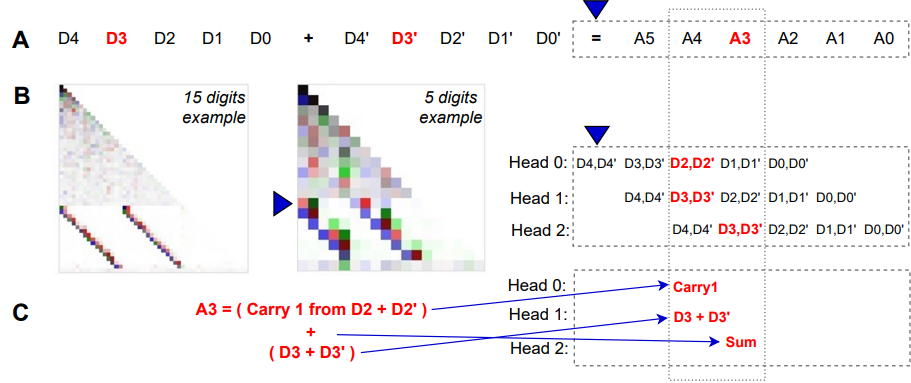

**A:** The 5 digit question is revealed token by token. The answer calculation starts at the “=" token (blue arrowhead). The highest-value digit is revealed first. **B:** The model heads focus on successive pairs of digits to be added, giving a “staircase" attention pattern visible in 15 digit, 5 digit, etc addition. The 3 heads are time-offset from each other by 1 token. **C:** Finalising the A3 answer requires the “carry 1" result from D2 + D2' which was calculated by Head 0 in the previous step.

### Show attention patterns for some randomly chosen tokens

In [33]:
def show_token_attention_patterns(index, token_at_index, use_case):
  attention_pattern=cache["pattern", 0, "attn"][index]

  # First token attention patterns
  the_tokens = [str(token) for token in token_at_index.tolist()]
  display(cv.attention.attention_patterns(
      tokens=the_tokens,
      attention=attention_pattern,
      attention_head_names=[f"L0H{i}" for i in range(4)],
  ))
  #print(the_tokens)
  #print(type(the_tokens))

  tokens_str = tokens_to_string(the_tokens)
  print(tokens_str)


sample_size = 3

# Show attention patterns for some randomly chosen tokens
for i in range(sample_size):
  show_token_attention_patterns(i, tokens[i], "Misc")


94560+44586=139146


67419+67315=134734


02206+02196=004402


In [34]:
if save_graph_pdf:
  # print(tokens)
  # print(type(tokens))

  tokens_str = []
  for i in range(3):
    one_token_str = []
    for j in tokens[i]:
      one_token_str.append(str(utils.to_numpy(j)))
    tokens_str.append(one_token_str)
  # print(tokens_str)
  # print(type(tokens_str))

  # Refer https://github.com/callummcdougall/CircuitsVis/blob/main/python/circuitsvis/circuitsvis_demo.ipynb

  html_object = cv.attention.from_cache(
      cache = cache,
      tokens = tokens_str, # list of list of strings
      return_mode = "html",
  )

  # Create a CoLab file containing the attention pattern(s) in HTML
  filename = "AttentionPattern" + str(n_digits) + "Digits" + str(n_heads) + "Heads.html"
  with open(filename, "w") as f:
      f.write(html_object.data)

  # Manually download the CoLab "html" file and open in your local browser.
  # Install and use the Edge extension "FireShot" to save a portion of the HTML page as a PDF

### Insights:

In mathematical addition every digit in the question is independent. No token impacts the likelihood of the next token. So the Murk is unpredictable. We assume the algorithm does not use the murk and so the residual stream is random at the end of the murk.

The attention only shows patterns after the full "question" has been revealed (post murk, in layer ~12). All Heads show a strong coherence, with a strong “staircase” pattern:
* They mainly attend to pairs of digits that need to be combined. This is expected and aligns with the BA etc task definitions.
* The staircase means the head attends to each pair of digits, from left (ten thousands digit) to right (units digit), in success layers (time slices). While a suboptimal ordering for human manual addition methods, this is the “order as written”.

Importantly, when viewing all heads in the (leftmost) image, the staircase is ~3 blocks wide. This means the head's staircases are offset horizontally from each other. Specifically:
* The H3 staircase is the right-most, meaning it is the first to attend to pair of tokens.
* The H0 staircase is in the middle.
* The H1 and H2 staircases overlap and are left-most, so they attend to pairs of digits last.



### Show attention patterns for some tokens which BA only



In [35]:
any_use_carry1s = torch.any(use_carry1s.bool(), dim=1)
no_use_carry1s = ~ any_use_carry1s
ba_num_cases = utils.to_numpy(torch.sum(no_use_carry1s))
if ba_num_cases >= sample_size :
  print(f"Attention patterns for first few BA-only tokens ({ba_num_cases} of {tokens.shape[0]})")
  ba_tokens = tokens[no_use_carry1s==1]
  for i in range(sample_size):
    show_token_attention_patterns(i, ba_tokens[i], "BAOnly")

Attention patterns for first few BA-only tokens (6 of 64)


01441+13303=014744


50461+97205=147666


16130+63800=079930


Show attention patterns for some tokens which UC1 (and not US9)

In [36]:
num_use_carry1s = torch.sum(use_carry1s, dim=1)
any_use_carry1s = torch.where( num_use_carry1s != 0, 1, 0 ) # At least one digit uses UC1
num_sum9s = torch.sum(use_sum9s, dim=1)
no_sum9s = torch.where( num_sum9s == 0, 1, 0 ) # No digits have Sum9 true
filtered_cases = any_use_carry1s & no_sum9s
uc1_num_cases = utils.to_numpy(torch.sum(filtered_cases))
if uc1_num_cases >= sample_size :
  print(f"Attention patterns for first few UC1-only (and not US9) tokens ({uc1_num_cases} of {tokens.shape[0]})")
  uc1_tokens = tokens[filtered_cases==1]
  for i in range(sample_size):
    show_token_attention_patterns(i, uc1_tokens[i], "UC1")

Attention patterns for first few UC1-only (and not US9) tokens (43 of 64)


94560+44586=139146


67419+67315=134734


82783+56421=139204


Show attention patterns for some tokens which US9

In [37]:
num_sum9s = torch.sum(use_sum9s, dim=1)
any_sum9s = torch.where( num_sum9s != 0, 1, 0 ) # At least one digit uses Sum9
us9_cases = utils.to_numpy(torch.sum(any_sum9s))
if us9_cases >= sample_size :
  print(f"Attention patterns for first few US9 tokens ({us9_cases} of {tokens.shape[0]})")
  us9_tokens = tokens[any_sum9s==1]
  for i in range(sample_size):
    show_token_attention_patterns(i, us9_tokens[i], "US9")

Attention patterns for first few US9 tokens (15 of 64)


02206+02196=004402


75596+89430=165026


64184+29853=094037


# Prediction Analysis - Looking at Activations

No insights gained from this section so far.

In [38]:
#Org px.imshow(cache["pattern", 0].mean(dim=0)[:, -1, :], title="Average Attention Pattern per Head", xaxis="Source", yaxis="Head", x=['a', 'b', '='])
px.imshow(cache["pattern", 0].mean(dim=0)[:, -1, :].cpu(), title="Average Attention Pattern per Head", labels={"x":"Source", "y":"Head"})


In [39]:
p = 8
#Org px.imshow(cache["pattern", 0][:, 0, -1, 0].reshape(p, p), title="Attention for Head 0 from a -> =", xaxis="b", yaxis="a")
px.imshow(cache["pattern", 0][:, 0, -1, 0].reshape(p, p).cpu(), title="Attention for Head 0 from a -> =", labels={"x":"b", "y":"a"})


In [40]:
# Org px.imshow(
#    einops.rearrange(cache["pattern", 0][:, :, -1, 0], "(a b) head -> head a b", a=p, b=p),
#    title="Attention for Head 0 from a -> =", xaxis="b", yaxis="a", facet_col=0)

px.imshow(
   einops.rearrange(cache["pattern", 0][:, :, -1, 0].cpu(), "(a b) head -> head a b", a=p, b=p),
   title="Attention for Head 0 from a -> =", labels={"x":"b", "y":"a"}, facet_col=0)

Plotting neuron activations

In [41]:
cache["post", 0, "mlp"].shape

torch.Size([64, 18, 2040])

In [42]:
# Org px.imshow(
#     einops.rearrange(neuron_acts[:, :5], "(a b) neuron -> neuron a b", a=p, b=p),
#     title="First 5 neuron acts", xaxis="b", yaxis="a", facet_col=0)

px.imshow(
  einops.rearrange(neuron_acts[:, :5].cpu(), "(a b) neuron -> neuron a b", a=p, b=p),
  title="First 5 neuron acts", labels={"x":"b", "y":"a"}, facet_col=0)

Singular Value Decomposition

In [43]:
U, S, Vh = torch.svd(W_E)
line(S, title="Singular Values")
imshow(U, title="Principal Components on the Input")

In [44]:
U, S, Vh = torch.svd(W_E)
line(S, title="Singular Values")
imshow(U, title="Principal Components on the Input")

In [45]:
# Control - random Gaussian matrix
U, S, Vh = torch.svd(torch.randn_like(W_E))
line(S, title="Singular Values Random")
imshow(U, title="Principal Components Random")

In [46]:
U, S, Vh = torch.svd(W_E)
line(U[:, :8].T, title="Principal Components of the embedding", xaxis="Input Vocabulary")

# Ablate one head at a time
Ablating is an experimentation technique where we alter a specific component of a model to see the resulting impact on the model's ability to perform its function.  

The model can be successfully trained with 2, 3 or 4 attention heads.

Using three heads give attention patterns which best help understand the algorithm. And with 3 heads, ablating any head increases the model loss, showing all 3 heads are useful.

Using four heads, ablating 2 heads increases loss (good), but ablating the 2 other heads reduces loss (bad). This is because these two heads are "spliting" a single task. Heads are independent and are additive, so this can occur.


In [47]:
layer_to_ablate = 0
head_index_to_ablate = 2

# Define a head ablation hook
def head_ablation_hook(
    value: Float[torch.Tensor, "batch pos head_index d_head"],
    hook: HookPoint
) -> Float[torch.Tensor, "batch pos head_index d_head"]:
    #print(f"Shape of the value tensor: {value.shape}")
    value[:, :, head_index_to_ablate, :] = 0.
    return value

print("Positive delta means better (reduced loss). Negative delta means worse (increased loss).")

original_loss = model(tokens, return_type="loss")
print(f"Original Loss: {original_loss.item():.3f}")

fwd_hooks=[(
    utils.get_act_name("v", layer_to_ablate),
    head_ablation_hook
    )]

for head_index_to_ablate in range(n_heads):

  ablated_loss = model.run_with_hooks(
      tokens,
      return_type="loss",
      fwd_hooks=fwd_hooks)
  all_tokens_delta_loss_perc = 100.0 * (original_loss - ablated_loss.item()) / original_loss

  if ba_num_cases > 0 :
    ablated_loss = model.run_with_hooks(
          ba_tokens,
          return_type="loss",
          fwd_hooks=fwd_hooks)
    ba_tokens_delta_loss_perc = 100 * (original_loss - ablated_loss.item()) / original_loss
  else:
    ba_tokens_delta_loss_perc = 0

  if uc1_num_cases > 0 :
    ablated_loss = model.run_with_hooks(
        uc1_tokens,
        return_type="loss",
        fwd_hooks=fwd_hooks)
    uc1_tokens_delta_loss_perc = 100 * (original_loss - ablated_loss.item()) / original_loss
  else:
    uc1_tokens_delta_loss_perc = 0

  if us9_cases > 0 :
    ablated_loss = model.run_with_hooks(
        us9_tokens,
        return_type="loss",
        fwd_hooks=fwd_hooks)
    us9_tokens_delta_loss_perc = 100 * (original_loss - ablated_loss.item()) / original_loss
  else:
    us9_tokens_delta_loss_perc = 0

  print(f"Ablated delta loss for head {head_index_to_ablate}: "+
        f"All={all_tokens_delta_loss_perc:.0f}% "+
        f"BA={ba_tokens_delta_loss_perc:.0f}% "+
        f"UC1={uc1_tokens_delta_loss_perc:.0f}% "+
        f"US9={us9_tokens_delta_loss_perc:.0f}% ")


Positive delta means better (reduced loss). Negative delta means worse (increased loss).
Original Loss: 5.401
Ablated delta loss for head 0: All=-9% BA=-7% UC1=-6% US9=-15% 
Ablated delta loss for head 1: All=12% BA=17% UC1=9% US9=17% 
Ablated delta loss for head 2: All=-2% BA=6% UC1=-2% US9=-4% 


## Corrupted Query

Another prediction investigation technique is to get the model to answer a question, and then corrupt the question and seem how the answer is impacted. This helps gain insight into what aspects of the question the model depends on.

In the integer addition case, **all** questions are valid. "Corrupting" a question digit by changing it to another digit, simply yields a new valid question with a different answer. Hence this technique does not seem applicable.

## Residual Head Patching

As per the above, I cant see a way to utilise this technique in this integer addition model.

## Logit Lens
From https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb
"Fascinatingly, we see that the model is utterly unable to do the task until layer 7, almost all performance comes from attention layer 9, and performance actually decreases from there. Layer k of a transformer means the kth transformer block, but each block consists of an attention layer (to move information around) and an MLP layer (to process information)."

In this integer addition model, we only have 1 layer, and the behaviour of the model when asked a question is covered in the Attention Pattern section above. Hence not seeing value in this technique for this model.   

## Head Attribution
From https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb
"We can further break down the output of each attention layer into the sum of the outputs of each attention head. Each attention layer consists of 12 heads, which each act independently and additively. We see that only a few heads really matter - heads L9H6 and L9H9 contribute a lot positively (explaining why attention layer 9 is so important), while heads L10H7 and L11H10 contribute a lot negatively (explaining why attention layer 10 and layer 11 are actively harmful)."

In this integer addition model, we only have a 1 layer, and the n_heads has manually tuned to 3, to give the "most readable" Attention Pattern. Hence not seeing value in this technique for this model.